In [1]:
import os
import ast
import json

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from utils import constants
from spatiotemporal_cnn.models import SpatiotemporalCNN

In [2]:
def summarize(path, fname, name):
    model_meta = pd.read_csv(os.path.join(path, fname))
    def replace(x):
        try:
            return ast.literal_eval(x)
        except:
            return x
    for col in ['pretrain_train_losses', 'pretrain_valid_losses', 'pretrain_train_acc', 'pretrain_valid_acc', 'pretrain_grad_norm',
                'train_losses', 'valid_losses', 'train_acc', 'valid_acc', 'grad_norm']:
        try:
            model_meta[col] = model_meta[col].apply(replace)
        except:
            pass

    model_meta['epochs'] = model_meta['train_losses'].apply(len)
    model_meta['final_train_loss'] = model_meta['train_losses'].apply(lambda x: x[-1])
    model_meta['final_grad_norm'] = model_meta['grad_norm'].apply(lambda x: x[-1])
    model_meta = model_meta.assign(approach=name)

    return model_meta

In [3]:
def read_cnn_results(root_dir, exp_dir, subject=None):
    args = exp_dir.split('_')[1:]
    df = summarize(os.path.join(root_dir, exp_dir, f's_{subject}' if subject is not None else ''), 'trial_results.csv', 'eegnet')

    df = df.assign(impute=args[0])
    df = df.assign(F1=int(args[1].split('-')[0]))
    df = df.assign(D=int(args[2].split('-')[0]))
    df = df.assign(F2=int(args[3].split('-')[0]))
    df = df.assign(weight_decay=float(args[4].split('-')[0]))
    df = df.assign(dropout=float(args[5].split('-')[0]))
    
    return df

In [116]:
all_model_df = pd.DataFrame()

root_dir = os.path.join(constants.RESULTS_DIR,
                        'motor_LR', 'spatiotemporal_cnn', 'voxel_space', 'rl', 'no_bandpass', 'max_abs_scale',
                        '4_montages', 'cropped', 'scale_2D', 'dual_ph_dc_viable_vox', 'dc_13_20')

subject = '516'

for d in os.listdir(root_dir):
    try:
        df = read_cnn_results(root_dir, d, subject if subject is not None else None)
        all_model_df = all_model_df.append(df, ignore_index=True)
    except OSError as e:
        print(e)
    
train_cols = ['train_accuracy', 'train_precision', 'train_recall', 'train_f1']
final_train_cols = ['final_'+metric for metric in train_cols]
valid_cols = ['valid_accuracy', 'valid_precision', 'valid_recall', 'valid_f1']
final_valid_cols = ['final_'+metric for metric in valid_cols]
test_cols = ['test_accuracy', 'test_precision', 'test_recall', 'test_f1']
final_test_cols = ['final_'+metric for metric in test_cols]

In [117]:
all_model_df.columns

Index(['cv_iter', 'Status', 'epoch_early_stop', 'final_test_accuracy',
       'final_test_auc', 'final_test_f1', 'final_test_loss',
       'final_test_precision', 'final_test_recall', 'final_train_accuracy',
       'final_train_auc', 'final_train_f1', 'final_train_precision',
       'final_train_recall', 'final_valid_accuracy', 'final_valid_auc',
       'final_valid_f1', 'final_valid_precision', 'final_valid_recall',
       'grad_norm', 'montage', 'subject', 'test_accuracy', 'test_auc',
       'test_f1', 'test_precision', 'test_recall', 'train_acc',
       'train_accuracy', 'train_auc', 'train_f1', 'train_losses',
       'train_precision', 'train_recall', 'valid_acc', 'valid_accuracy',
       'valid_auc', 'valid_f1', 'valid_losses', 'valid_precision',
       'valid_recall', 'epochs', 'final_train_loss', 'final_grad_norm',
       'approach', 'impute', 'F1', 'D', 'F2', 'weight_decay', 'dropout'],
      dtype='object')

In [118]:
all_model_df.F1.unique()

array([ 8, 12,  6])

In [119]:
montage_order = ['A', 'B', 'C', 'D']

Display best hyperparameter settings for each montage

In [120]:
grouped_df = all_model_df.groupby(['montage', 'F1', 'D', 'F2', 'weight_decay', 'dropout']).mean()[test_cols + valid_cols]
best_acc_idx = grouped_df.reset_index().groupby('montage').idxmax()['valid_accuracy']
best_acc_montage = grouped_df.reset_index().loc[best_acc_idx.values, :].reset_index(drop=True).round(5)
best_acc_montage

,montage,F1,D,F2,weight_decay,dropout,test_accuracy,test_precision,test_recall,test_f1,valid_accuracy,valid_precision,valid_recall,valid_f1
0,A,8,8,12,0.0001,0.5,0.62174,0.62138,0.64348,0.62948,0.76021,0.75603,0.78889,0.76382
1,B,8,8,12,0.0001,0.5,0.54348,0.54409,0.53043,0.53656,0.72568,0.73115,0.73216,0.72595
2,C,12,12,12,0.0001,0.5,0.54348,0.53646,0.63478,0.58034,0.69745,0.68890,0.74912,0.71451
3,D,6,12,12,0.0001,0.5,0.56087,0.55400,0.60870,0.57903,0.64339,0.64030,0.68129,0.65534


## Analyze montage-specific performance for montage-specific parameter settings

In [121]:
chosen_params = dict()
for i in best_acc_montage.index:
    m = best_acc_montage.loc[i, 'montage']
    chosen_params[m] = best_acc_montage.loc[i, ['F1', 'D', 'F2', 'weight_decay', 'dropout']].to_dict()
chosen_params

{'A': {'F1': 8, 'D': 8, 'F2': 12, 'weight_decay': 0.0001, 'dropout': 0.5},
 'B': {'F1': 8, 'D': 8, 'F2': 12, 'weight_decay': 0.0001, 'dropout': 0.5},
 'C': {'F1': 12, 'D': 12, 'F2': 12, 'weight_decay': 0.0001, 'dropout': 0.5},
 'D': {'F1': 6, 'D': 12, 'F2': 12, 'weight_decay': 0.0001, 'dropout': 0.5}}

In [122]:
all_montage_df = pd.DataFrame()

for m, params in chosen_params.items():
    curr_montage_df = all_model_df[(all_model_df['montage'] == m) & 
                                   (all_model_df['F1'] == params['F1']) &
                                   (all_model_df['D'] == params['D']) & 
                                   (all_model_df['F2'] == params['F2'])].copy()
    melted = pd.melt(curr_montage_df,
                     id_vars = ['F1', 'D', 'F2', 'weight_decay', 'dropout', 'montage'],
                     value_vars = ['test_accuracy', 'test_precision', 'test_recall', 'test_f1'],
                     var_name = 'metric')
    melted.loc[:, 'metric'] = melted.loc[:, 'metric'].apply(lambda x: x.split('_')[1].capitalize())
    all_montage_df = all_montage_df.append(melted, ignore_index=True)

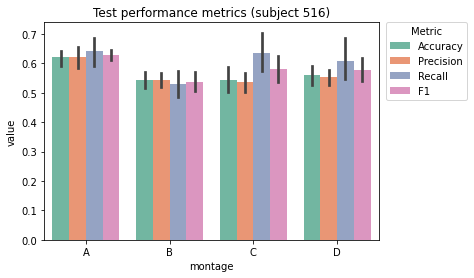

In [123]:
fig, ax = plt.subplots(1, 1)

sns.barplot(data=all_montage_df,
            x='montage', y='value', hue='metric', palette='Set2', ax=ax, order=montage_order)
plt.legend(title='Metric', bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)
plt.title(f'Test performance metrics (subject {subject})');

In [124]:
best_acc_montage.mean()[test_cols]

test_accuracy     0.567392
test_precision    0.563983
test_recall       0.604348
test_f1           0.581353
dtype: float64

## Analyze montage-specific performance for fixed parameter settings

In [42]:
impute = 'zero'
F1 = 6
D = 12
F2 = 12
weight_decay = 0.0001
dropout = 0.5

In [15]:
f = open(os.path.join(root_dir, f'eegnet_{impute}_{F1}-F1_{D}-D_{F2}-F2_{weight_decay}-L2_{dropout}-p',
                      f's_{subject}', 'args.json'))
args = json.load(f)

In [183]:
model = SpatiotemporalCNN(args['num_channels'],
                          F1=args['num_temporal_filters'],
                          D=args['num_spatial_filters'],
                          F2=args['num_pointwise_filters'],
                          p=args['dropout'], fs=args['fs'], T=args['seq_len'],)

In [184]:
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(f'{params} trainable parameters')

16501 trainable parameters


### Test performance metrics (barplot)

In [185]:
melt_test = pd.melt(all_model_df,
                    id_vars = ['impute', 'F1', 'D', 'F2', 'weight_decay', 'dropout', 'montage'],
                    value_vars = ['test_accuracy', 'test_precision', 'test_recall', 'test_f1'],
                    var_name = 'metric')
melt_test.loc[:, 'metric'] = melt_test.loc[:, 'metric'].apply(lambda x: x.split('_')[1].capitalize())

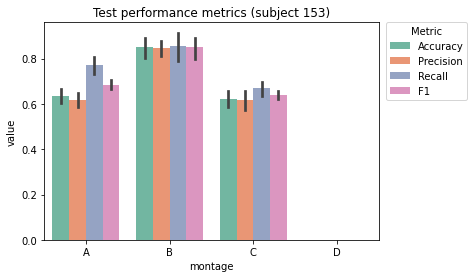

In [186]:
fig, ax = plt.subplots(1, 1)

sns.barplot(data=melt_test[(melt_test['impute'] == impute) &
                           (melt_test['F1'] == F1) &
                           (melt_test['D'] == D) & 
                           (melt_test['F2'] == F2) &
                           (melt_test['weight_decay'] == weight_decay) &
                           (melt_test['dropout'] == dropout)],
            x='montage', y='value', hue='metric', palette='Set2', ax=ax, order=montage_order)
plt.legend(title='Metric', bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)
plt.title(f'Test performance metrics (subject {subject})');

In [187]:
output_df = all_model_df[(all_model_df['impute'] == impute) &
                         (all_model_df['F1'] == F1) &
                         (all_model_df['D'] == D) & 
                         (all_model_df['F2'] == F2) &
                         (all_model_df['weight_decay'] == weight_decay) &
                         (all_model_df['dropout'] == dropout)].groupby('montage').mean()
output_df[test_cols + valid_cols + train_cols + ['epochs']].round(3)

,test_accuracy,test_precision,test_recall,test_f1,valid_accuracy,valid_precision,valid_recall,valid_f1,train_accuracy,train_precision,train_recall,train_f1,epochs
montage,,,,,,,,,,,,,
A,0.636,0.617,0.774,0.685,0.819,0.838,0.815,0.824,0.972,0.971,0.976,0.973,300
B,0.852,0.848,0.857,0.852,0.911,0.900,0.929,0.913,0.951,0.950,0.953,0.951,300
C,0.622,0.616,0.670,0.640,0.739,0.740,0.767,0.744,0.918,0.922,0.911,0.916,300


In [188]:
output_df[test_cols + valid_cols + train_cols + ['epochs']].mean().round(3)

test_accuracy        0.703
test_precision       0.694
test_recall          0.767
test_f1              0.725
valid_accuracy       0.823
valid_precision      0.826
valid_recall         0.837
valid_f1             0.827
train_accuracy       0.947
train_precision      0.948
train_recall         0.947
train_f1             0.947
epochs             300.000
dtype: float64

### Early stopping (validation accuracy) test accuracy

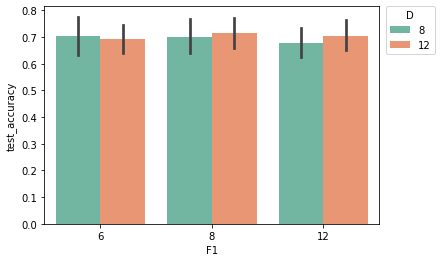

In [189]:
fig, ax = plt.subplots(1, 1)

sns.barplot(data=all_model_df[(all_model_df['F2'] == F2) &
                              (all_model_df['weight_decay'] == weight_decay) &
                              (all_model_df['dropout'] == dropout)],
            x='F1', y='test_accuracy', hue='D', palette='Set2', ax=ax, order=sorted(all_model_df.F1.unique()))
plt.legend(title='D', bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)
plt.title(f'');

### Final test accuracy

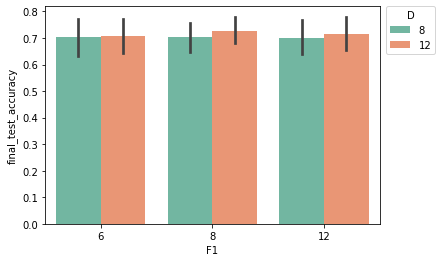

In [190]:
fig, ax = plt.subplots(1, 1)

sns.barplot(data=all_model_df[(all_model_df['F2'] == F2) &
                              (all_model_df['weight_decay'] == weight_decay) &
                              (all_model_df['dropout'] == dropout)],
            x='F1', y='final_test_accuracy', hue='D', palette='Set2', ax=ax, order=sorted(all_model_df.F1.unique()))
plt.legend(title='D', bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)
plt.title(f'');

### Early stopping (validation accuracy) train accuracy

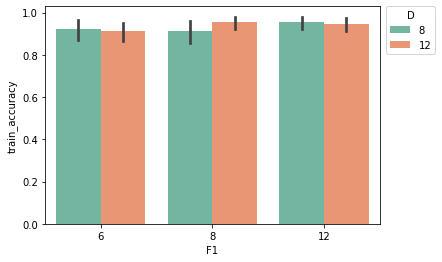

In [191]:
fig, ax = plt.subplots(1, 1)

sns.barplot(data=all_model_df[(all_model_df['F2'] == F2) &
                              (all_model_df['weight_decay'] == weight_decay) &
                              (all_model_df['dropout'] == dropout)],
            x='F1', y='train_accuracy', hue='D', palette='Set2', ax=ax, order=sorted(all_model_df.F1.unique()))
plt.legend(title='D', bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)
plt.title(f'');

### Final train accuracy

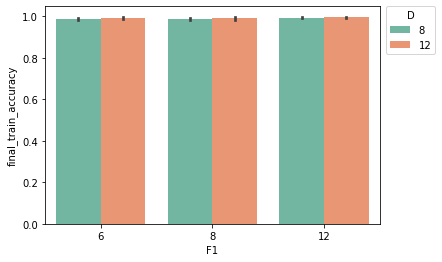

In [192]:
fig, ax = plt.subplots(1, 1)

sns.barplot(data=all_model_df[(all_model_df['F2'] == F2) &
                              (all_model_df['weight_decay'] == weight_decay) &
                              (all_model_df['dropout'] == dropout)],
            x='F1', y='final_train_accuracy', hue='D', palette='Set2', ax=ax, order=sorted(all_model_df.F1.unique()))
plt.legend(title='D', bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)
plt.title(f'');

In [193]:
output_df = all_model_df[(all_model_df['impute'] == impute) &
                         (all_model_df['F1'] == F1) &
                         (all_model_df['D'] == D) & 
                         (all_model_df['F2'] == F2) &
                         (all_model_df['weight_decay'] == weight_decay) &
                         (all_model_df['dropout'] == dropout)].groupby('montage').mean()
output_df[final_test_cols + final_valid_cols + final_train_cols + ['epochs']].round(3)

,final_test_accuracy,final_test_precision,final_test_recall,final_test_f1,final_valid_accuracy,final_valid_precision,final_valid_recall,final_valid_f1,final_train_accuracy,final_train_precision,final_train_recall,final_train_f1,epochs
montage,,,,,,,,,,,,,
A,0.653,0.630,0.791,0.700,0.734,0.734,0.771,0.749,1.000,1.000,1.000,1.000,300
B,0.881,0.855,0.924,0.887,0.827,0.821,0.847,0.830,0.991,0.988,0.994,0.991,300
C,0.613,0.596,0.713,0.648,0.617,0.618,0.622,0.615,0.994,0.994,0.994,0.994,300


In [194]:
output_df = output_df[['F1', 'D', 'F2'] + test_cols].round(3)
output_df.reset_index(inplace=True)
output_df.set_index = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']
print(output_df.to_latex(index=False,
                         header=['Montage', 'F1', 'D', 'F2', 'Accuracy', 'Precision', 'Recall', 'F1']))

\begin{tabular}{lrrrrrrr}
\toprule
Montage &  F1 &   D &  F2 & Accuracy & Precision & Recall &     F1 \\
\midrule
      A &  12 &  12 &  12 &    0.636 &     0.617 &  0.774 &  0.685 \\
      B &  12 &  12 &  12 &    0.852 &     0.848 &  0.857 &  0.852 \\
      C &  12 &  12 &  12 &    0.622 &     0.616 &  0.670 &  0.640 \\
\bottomrule
\end{tabular}



## Train/Valid Losses

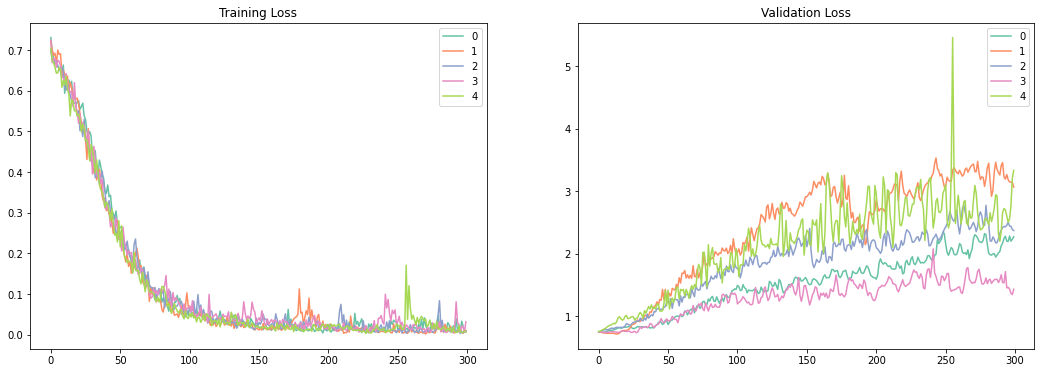

In [16]:
impute = 'zero'
# F1 = 8
# D = 12
# F2 = 12
# weight_decay = 0.0001
# dropout = 0.5
montage = 'A'

subset_df = all_model_df[(all_model_df['impute'] == impute) &
                         (all_model_df['F1'] == F1) &
                         (all_model_df['D'] == D) & 
                         (all_model_df['F2'] == F2) & 
                         (all_model_df['weight_decay'] == weight_decay) &
                         (all_model_df['dropout'] == dropout) &
                         (all_model_df['montage'] == montage)]

n = len(subset_df)
colors = plt.cm.Set2(np.linspace(0, 1, 8))

fig, ax = plt.subplots(1, 2, figsize=(18, 6))
for i, idx in enumerate(subset_df.index):
    ax[0].plot(subset_df.loc[idx, 'train_losses'], color=colors[i])
    ax[1].plot(subset_df.loc[idx, 'valid_losses'], color=colors[i])
    ax[0].set_title('Training Loss')
    ax[1].set_title('Validation Loss')
    if subject is not None:
        ax[0].legend(subset_df.cv_iter.unique())
        ax[1].legend(subset_df.cv_iter.unique())
    else:
        ax[0].legend(subset_df.subject.unique())
        ax[1].legend(subset_df.subject.unique())

## Train/Valid Accuracies

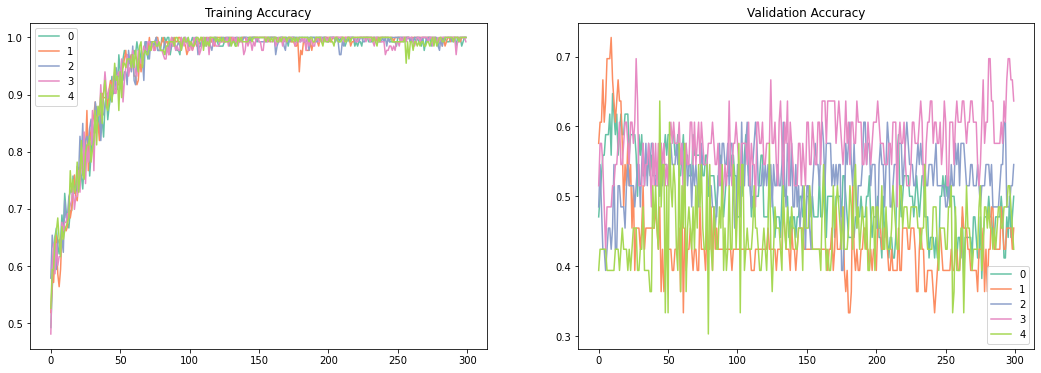

In [17]:
subset_df = all_model_df[(all_model_df['impute'] == impute) &
                         (all_model_df['F1'] == F1) &
                         (all_model_df['D'] == D) & 
                         (all_model_df['F2'] == F2) & 
                         (all_model_df['weight_decay'] == weight_decay) &
                         (all_model_df['dropout'] == dropout) &
                         (all_model_df['montage'] == montage)]

n = len(subset_df)
colors = plt.cm.Set2(np.linspace(0, 1, 8))

fig, ax = plt.subplots(1, 2, figsize=(18, 6))
for i, idx in enumerate(subset_df.index):
    ax[0].plot(subset_df.loc[idx, 'train_acc'], color=colors[i])
    ax[1].plot(subset_df.loc[idx, 'valid_acc'], color=colors[i])
    ax[0].set_title('Training Accuracy')
    ax[1].set_title('Validation Accuracy')
    if subject is not None:
        ax[0].legend(subset_df.cv_iter.unique())
        ax[1].legend(subset_df.cv_iter.unique())
    else:
        ax[0].legend(subset_df.subject.unique())
        ax[1].legend(subset_df.subject.unique())

## Gradient Norm

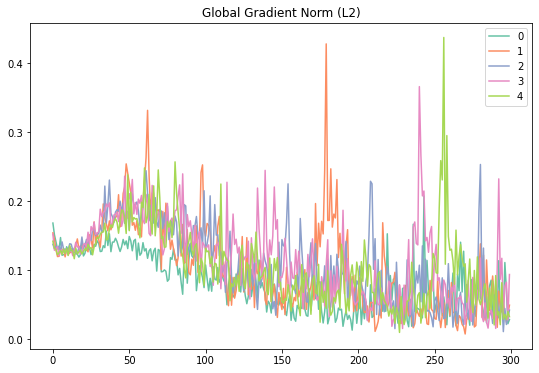

In [18]:
subset_df = all_model_df[(all_model_df['impute'] == impute) &
                         (all_model_df['F1'] == F1) &
                         (all_model_df['D'] == D) & 
                         (all_model_df['F2'] == F2) & 
                         (all_model_df['weight_decay'] == weight_decay) &
                         (all_model_df['dropout'] == dropout) &
                         (all_model_df['montage'] == montage)]

n = len(subset_df)
colors = plt.cm.Set2(np.linspace(0, 1, 8))

fig, ax = plt.subplots(1, 1, figsize=(9, 6))
for i, idx in enumerate(subset_df.index):
    ax.plot(subset_df.loc[idx, 'grad_norm'], color=colors[i])
    ax.set_title('Global Gradient Norm (L2)')
    if subject is not None:
        ax.legend(subset_df.cv_iter.unique())
    else:
        ax.legend(subset_df.subject.unique())

## View predictions

In [19]:
impute = 'zero'
# F1 = 6
# D = 8
# F2 = 12
# weight_decay = 0.0001
# dropout = 0.5
# montage = 'all'
phase = 'test'
final = False
cv_iter = 0

exp_dir = f'eegnet_{impute}_{F1}-F1_{D}-D_{F2}-F2_{weight_decay}-L2_{dropout}-p'

def aggregate_predictions(root_dir, exp_dir, subject, montage, phase):
    
    out_df = pd.DataFrame()
    for i in range(5):
        df = pd.read_parquet(
            os.path.join(root_dir, exp_dir,
                         f's_{subject}' if subject is not None else '',
                         'final_predictions' if final else 'predictions',
                         f'{subject}_{montage}_{phase}_{i}.parquet'))
        out_df = out_df.append(df, ignore_index=True)
        
    return out_df

pred_df = aggregate_predictions(root_dir, exp_dir, subject, montage, phase)
pred_df['pred'] = pred_df['pred'].astype(np.float32)
subset_df = pred_df[pred_df['cv_iter'] == cv_iter]
subset_df

,subject_id,montage,cv_iter,true,pred,prob
0,127,A,0,1.0,0.0,0.419043
1,127,A,0,1.0,0.0,0.484585
2,127,A,0,1.0,1.0,0.588107
3,127,A,0,0.0,0.0,0.381854
4,127,A,0,0.0,0.0,0.313886
5,127,A,0,0.0,0.0,0.402579
6,127,A,0,0.0,0.0,0.464350
7,127,A,0,1.0,1.0,0.709879
8,127,A,0,0.0,1.0,0.693768
9,127,A,0,0.0,1.0,0.560533


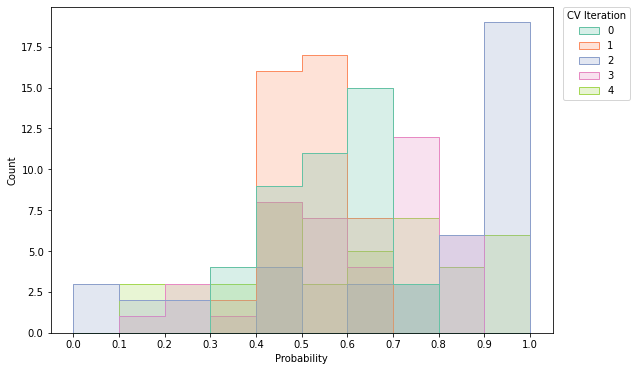

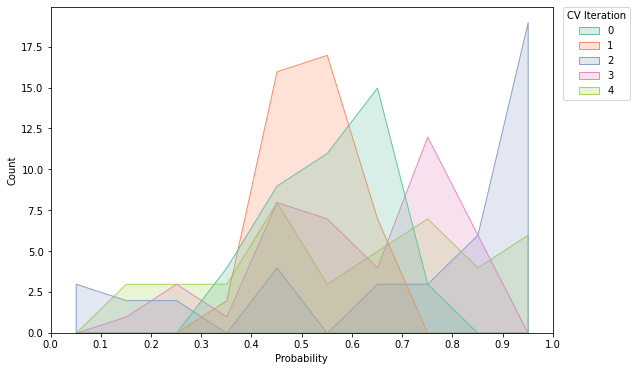

In [20]:
def move_legend(ax, new_title, new_loc, **kws):
    old_legend = ax.legend_
    handles = old_legend.legendHandles
    labels = [t.get_text() for t in old_legend.get_texts()]
    if new_title is not None:
        title = new_title
    else:
        title = old_legend.get_title().get_text()
    ax.legend(handles, labels, loc=new_loc, title=title, **kws)

fig, ax = plt.subplots(1, 1, figsize=(9, 6))

g = sns.histplot(data=pred_df, x='prob', hue='cv_iter', element='step', fill=True, binwidth=0.1, binrange=(0, 1),
                 palette='Set2', ax=ax)
g.set_xticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
move_legend(ax, new_title='CV Iteration', bbox_to_anchor=(1.02, 1), new_loc=2, borderaxespad=0.)
ax.set_xlabel('Probability');

fig, ax = plt.subplots(1, 1, figsize=(9, 6))

g = sns.histplot(data=pred_df, x='prob', hue='cv_iter', element='poly', fill=True, binwidth=0.1, binrange=(0, 1),
                 palette='Set2', ax=ax)
g.set_xticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
move_legend(ax, new_title='CV Iteration', bbox_to_anchor=(1.02, 1), new_loc=2, borderaxespad=0.)
ax.set_xlabel('Probability');

In [21]:
from sklearn.metrics import accuracy_score

accuracy_score(subset_df['true'], subset_df['pred'])

0.5714285714285714

In [22]:
np.bincount(subset_df.true.values.astype(int))

array([21, 21])

In [23]:
subset_df.pred.unique()

array([0., 1.], dtype=float32)

# Save cross-subject results

In [ ]:
all_subject_df = pd.DataFrame()

root_dir = os.path.join(constants.RESULTS_DIR,
                        'motor_LR', 'spatiotemporal_cnn', 'voxel_space', 'rl', 'no_bandpass', 'max_abs_scale',
                        '8_montages', 'cropped',  'baseline_viable_vox')
subjects = constants.SUBJECT_IDS

for d in os.listdir(root_dir):
    for subject in subjects:
        try:
            df = read_cnn_results(root_dir, d, subject if subject is not None else None)
            df.loc[:, 'subject_id'] = subject
            all_subject_df = all_subject_df.append(df, ignore_index=True)
        except OSError as e:
            pass

all_subject_df.loc[:, 'approach'] = 'Spatiotemporal CNN (viable voxels) baseline'

In [ ]:
all_subject_df.subject_id.unique()

In [ ]:
F1 = 12
D = 12
F2 = 12
weight_decay = 0.0001
dropout = 0.5

all_subject_df = all_subject_df[(all_subject_df['F1'] == F1) &
                                (all_subject_df['D'] == D) & 
                                (all_subject_df['F2'] == F2) &
                                (all_subject_df['weight_decay'] == weight_decay) &
                                (all_subject_df['dropout'] == dropout)]

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

sns.barplot(data=all_subject_df,
            x='montage', y='test_accuracy', hue='subject_id', palette='Set2', ax=ax, order=montage_order)
plt.legend(title='Subject', bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)
plt.title('Subject-specific test accuracy (across 5-folds of CV)');

In [ ]:
all_subject_df.to_parquet(
    os.path.join(constants.RESULTS_DIR, 'motor_LR', 'approach_tables', 'eegnet_baseline_viable_vox.parquet'))

In [ ]:
df = pd.read_parquet(os.path.join(constants.RESULTS_DIR, 'motor_LR', 'approach_tables', 'eegnet_baseline_viable_vox.parquet'))
df.columns